In [1]:
import numpy as np
import SimplisticSimulatedObs as SSO
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import image_filtering as imf
from importlib import reload
SSP=reload(SSO)

In [2]:
radius=3.0                                 # Radius of scan that we'll use (arcminutes)
tstep=1e-2                                 # An effective time sampling for MUSTANG-2 (after down-sampling)
x,y,t = SSO.scan_traj(radius,tstep=tstep)  # Routine to make a LJD scan trajectory
radpd  = 20*(radius/2)**(1.0/3.0)          # A "period" -- 2 petals are made in a period
petali = int(np.round(radpd / (4*tstep)))  # An idea of where the edge of the petal is (useful for plotting below)

In [3]:
pixid,xpix,ypix = SSO.mk_hex_array(10)

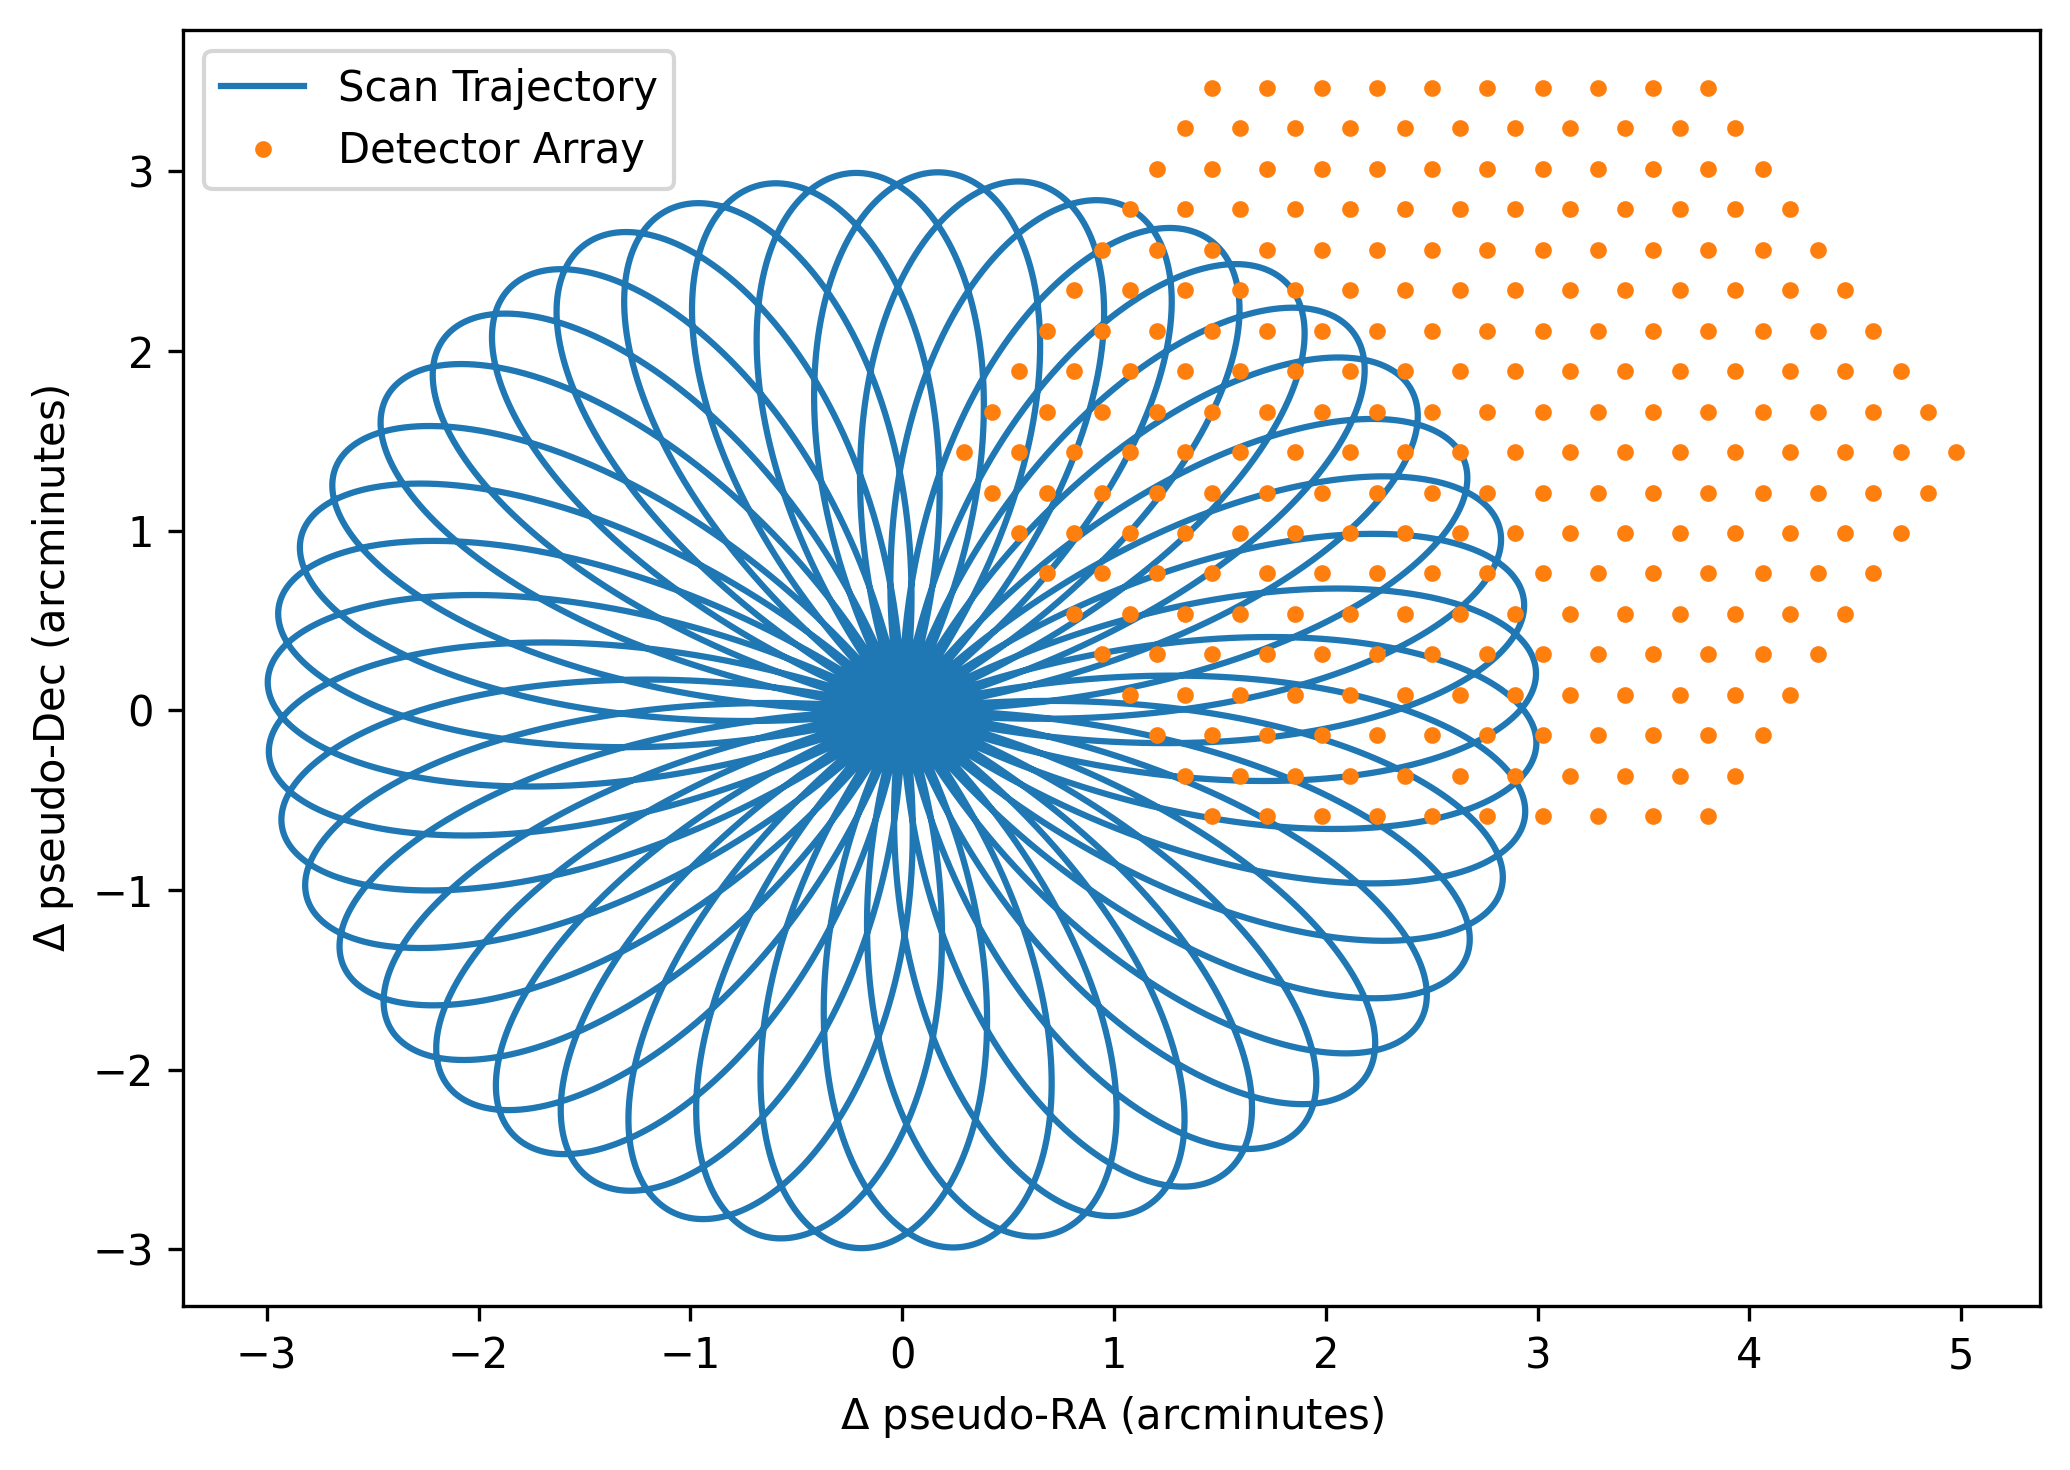

In [4]:
fig1 = plt.figure(1,figsize=(7,5),dpi=300)
fig1.clf()
ax1 = fig1.add_subplot(111)
ax1.plot(x,y,label="Scan Trajectory")
ind=petali
ax1.plot(xpix+x[ind],ypix+y[ind],'.',label="Detector Array")
ax1.set_xlabel(r"$\Delta$ pseudo-RA (arcminutes)")
ax1.set_ylabel(r"$\Delta$ pseudo-Dec (arcminutes)")
ax1.legend()
fig1.tight_layout()

In [5]:
scan = SSO.create_scan_template(x,y,t,xpix,ypix,pixid) # Get detector positions during a scan
xsize, ysize = 10.8,10.8 # 10.8 arcminute by 10.8 arcminute map
pixsize = 2.0 # with 2 arcsecond pixels
xm,ym = SSO.make_xymap(xsize,ysize,pixsize) # For each pixel, xm gives the x-coordinate (ym: the y-coordinate)
myamp = 2e-3 # Let's imagine that we're working in Kelvin (RJ)
x0,y0 = 15.0,10.0 # arcsecond positions (center of map is 0,0)
sj,sn = 40.0,35.0  # sigma_major, sigma_minor in arcseconds
theta = np.pi/4   # How is the major axis rotated relative to the x-axis?
twodg = SSO.make_2dgauss(xm,ym,x0,y0,sj,sn,theta,myamp)
nx,ny = xm.shape

In [6]:
maptod = SSO.map2tod(twodg,(xm,ym),scan)

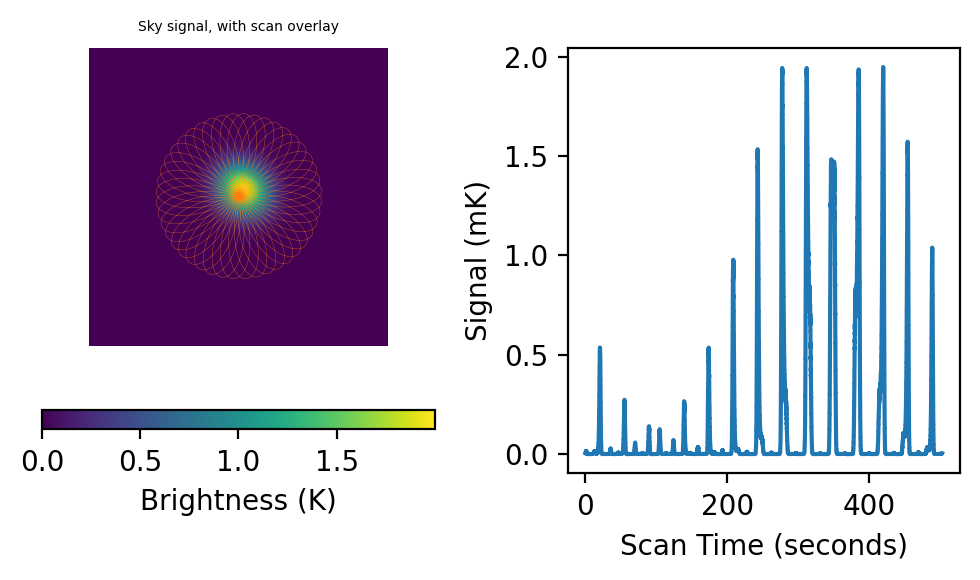

In [7]:
fig2 = plt.figure(2,figsize=(5,3),dpi=200)
fig2.clf()
ax2a = fig2.add_subplot(121)
ax2b = fig2.add_subplot(122)
ax2a.set_axis_off()
im2 = ax2a.imshow(twodg*1e3,origin="lower")
ax2a.plot(x*60/pixsize + nx/2,y*60/pixsize + ny/2,color='C1',lw=0.1)
#plt.colorbar(im2)
ax2b.plot(t,maptod[0,:]*1e3)
ax2b.set_xlabel("Scan Time (seconds)")
ax2b.set_ylabel("Signal (mK)")
ax2a.set_title("Sky signal, with scan overlay",fontsize=5)

plt.colorbar(im2,location="bottom",ax=ax2a,label="Brightness (K)")

#ax2.legend()
fig2.tight_layout()

In [8]:
cmsubbed = SSO.cmsub(maptod,scan["wts"]) # Subtract a common mode (average across detectors)

In [9]:
scan["vals"] = cmsubbed      # Put the TOD of your choice into the scan dictionary
cmsubonlymap,cmsowts = SSO.tod2map_v2((xm,ym),scan) # Then you can make a map like this

In [10]:
ffilt = [0.08,51.0] # high-pass and low-pass filters, in Hz
filttod = SSO.fourier_filter(t,maptod,ffilt) # Apply this filter to the TOD

In [11]:
scan["vals"] = filttod        # Again, scan vals must be replaced by your TOD
ffiltonlymap,ffowts = SSO.tod2map_v2((xm,ym),scan) # Same call sequence

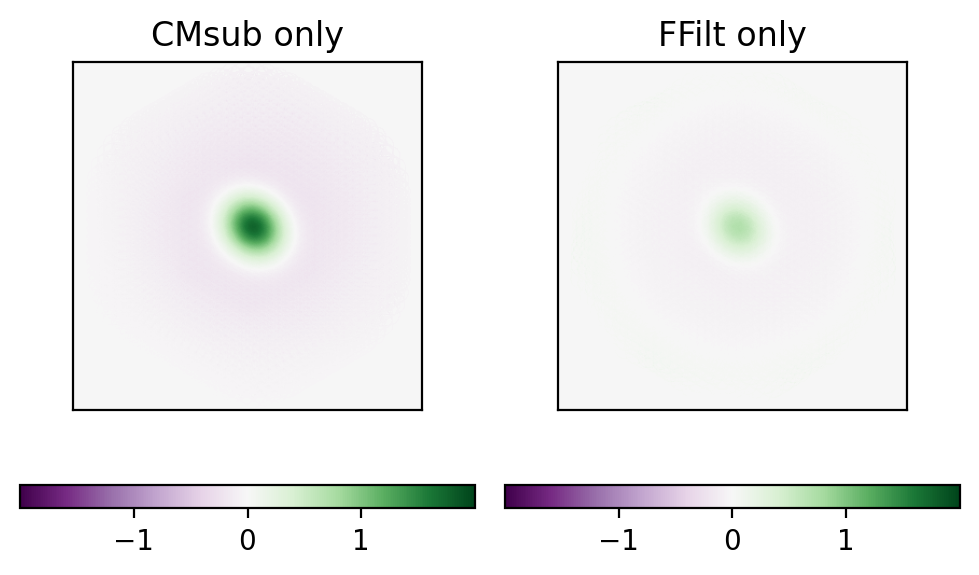

In [12]:
fig3 = plt.figure(3,figsize=(5,3),dpi=200)
fig3.clf()
vmax = np.max(twodg)*1e3 # in "mK" (or mJy?)
vmin = -vmax
norm=colors.Normalize(vmin=vmin, vmax=vmax) # Fairly important to SEE the difference
mycmap=cm.get_cmap('PRGn')

ax3a = fig3.add_subplot(121)
ax3a.axes.xaxis.set_visible(False)
ax3a.axes.yaxis.set_visible(False)
im3a = ax3a.imshow(cmsubonlymap*1e3,origin="lower",norm=norm,cmap=mycmap)
ax3b = fig3.add_subplot(122)
ax3b.axes.xaxis.set_visible(False)
ax3b.axes.yaxis.set_visible(False)
im3b = ax3b.imshow((ffiltonlymap)*1e3,origin="lower",norm=norm,cmap=mycmap)
ax3a.set_title("CMsub only")
ax3b.set_title("FFilt only")

plt.colorbar(im3a,location="bottom",ax=ax3a)
plt.colorbar(im3b,location="bottom",ax=ax3b)
fig3.tight_layout()

In [13]:
SSO=reload(SSO)
noise = SSO.create_noise(t,scan["ndet"],norm=1e0,slope=-4,knee = 1.0) # Dominated by atmospheric turbulence
grada = SSO.get_scan_atm(scan)   # Do a simplistic estimation of atmospheric gradient
noise = noise+grada              # Add that to our noise

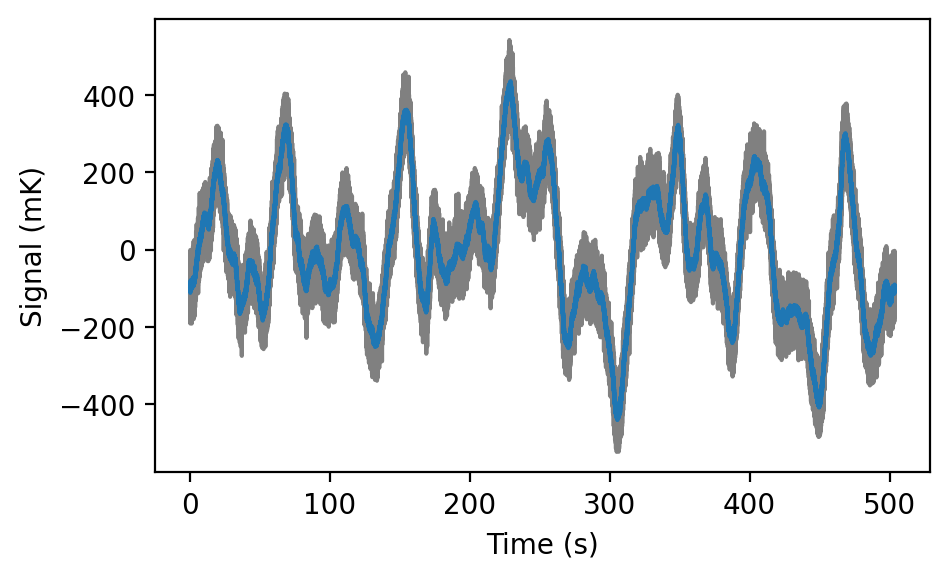

In [14]:
fig3b = plt.figure(3,figsize=(5,3),dpi=200)
fig3b.clf()
ax33 = fig3b.add_subplot(111)
ax33.set_ylabel("Signal (mK)")
ax33.set_xlabel("Time (s)")
cmode = np.mean(noise,axis=0)
for detnoise in noise[0:10,:]:
    ax33.plot(t,detnoise*1e3,color="grey")
ax33.plot(t,cmode*1e3,color="C0")

   

In [15]:
scan["vals"] = noise     # Put the TOD of your choice into the scan dictionary
SSO.set_wts(scan)        # We now have some noise (realistic or not), so we ought to update our weights
noiseonlymap,noiowts = SSO.tod2map_v2((xm,ym),scan) # Then you can make a map like this
scan["vals"] = grada     # Put the TOD of your choice into the scan dictionary
gradientmap,gradwts = SSO.tod2map_v2((xm,ym),scan) # Then you can make a map like this


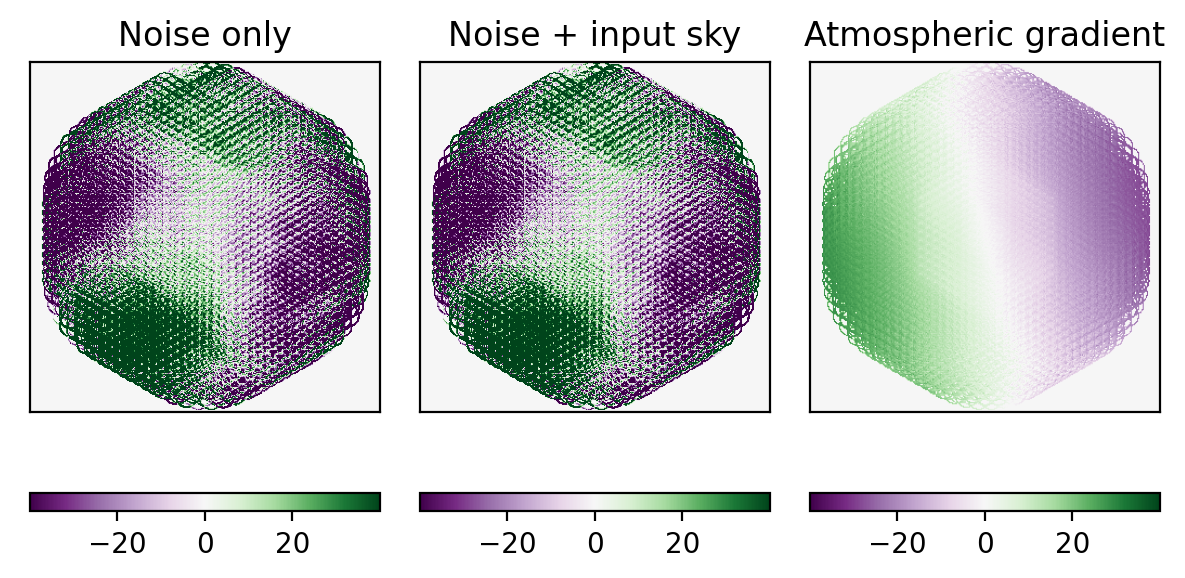

In [16]:
fig4 = plt.figure(4,figsize=(6,3),dpi=200)
fig4.clf()
vmax = np.max(twodg)*2e4 # in "mK" (or mJy?)
vmin = -vmax
norm=colors.Normalize(vmin=vmin, vmax=vmax) # Fairly important to SEE the difference
mycmap=cm.get_cmap('PRGn')

ax4a = fig4.add_subplot(131)
im4a = ax4a.imshow(noiseonlymap*1e3,origin="lower",norm=norm,cmap=mycmap)
ax4b = fig4.add_subplot(132)
im4b = ax4b.imshow((noiseonlymap+twodg)*1e3,origin="lower",norm=norm,cmap=mycmap)
ax4c = fig4.add_subplot(133)
im4c = ax4c.imshow((gradientmap)*1e3,origin="lower",norm=norm,cmap=mycmap)
ax4a.axes.xaxis.set_visible(False)
ax4a.axes.yaxis.set_visible(False)
ax4b.axes.xaxis.set_visible(False)
ax4b.axes.yaxis.set_visible(False)
ax4c.axes.xaxis.set_visible(False)
ax4c.axes.yaxis.set_visible(False)

ax4a.set_title("Noise only")
ax4b.set_title("Noise + input sky")
ax4c.set_title("Atmospheric gradient")

plt.colorbar(im4a,location="bottom",ax=ax4a)
plt.colorbar(im4b,location="bottom",ax=ax4b)
plt.colorbar(im4c,location="bottom",ax=ax4c)

fig4.tight_layout()

In [17]:
synth_tod   = noise + maptod # Let's say that it's as simply as adding noise to our model
ffilt       = [0.08,51.0]        # high-pass and low-pass filters, in Hz
synth_ffilt = SSO.fourier_filter(t,synth_tod,ffilt) # Apply this filter to the TOD
synth_cmsub = SSO.cmsub(synth_ffilt,scan["wts"])    # Subtract a common mode AFTER Fourier filtering
scan["vals"] = synth_cmsub     # Put the TOD of your choice into the scan dictionary
SSO.set_wts(scan)        # We now have some noise (realistic or not), so we ought to update our weights


In [18]:
reducedmap,redowts = SSO.tod2map_v2((xm,ym),scan) # Then you can make a map like this

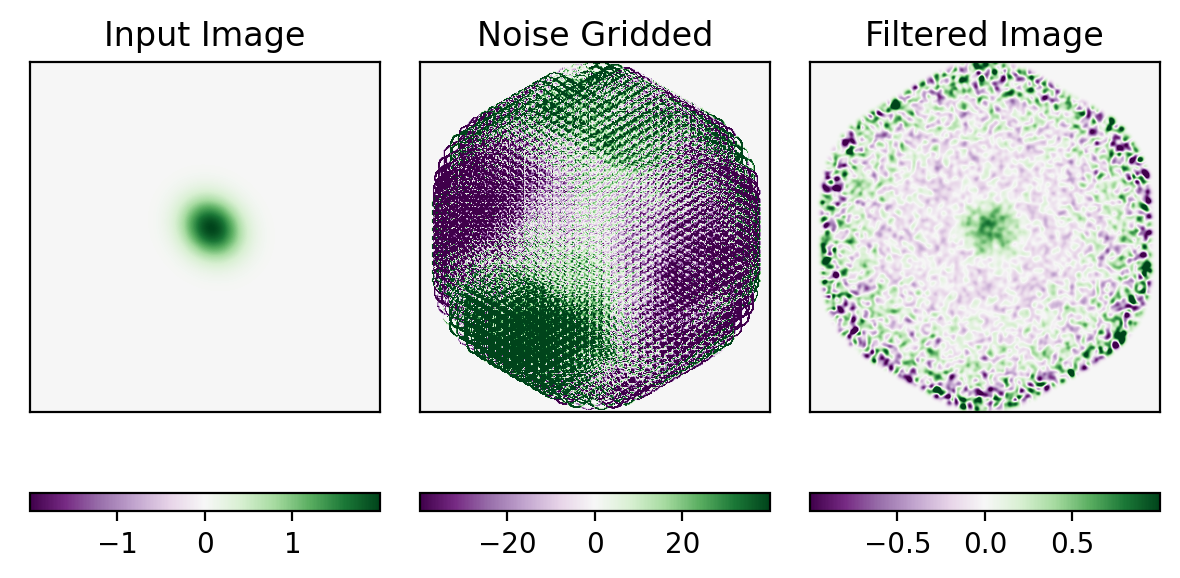

In [19]:
fig5 = plt.figure(5,figsize=(6,3),dpi=200)
fig5.clf()
vmax = np.max(twodg)*1e3 # in "mK" (or mJy?)
vmin = -vmax
norm=colors.Normalize(vmin=vmin, vmax=vmax) # Fairly important to SEE the difference
nhalf=colors.Normalize(vmin=vmin/2, vmax=vmax/2) # Fairly important to SEE the difference
noin=colors.Normalize(vmin=vmin*20, vmax=vmax*20) # Fairly important to SEE the difference
mycmap=cm.get_cmap('PRGn')
smfwhm = 9.0 # 10 arcsecond smoothing
smoothedmap = imf.fourier_filtering_2d(reducedmap,"gauss",smfwhm/pixsize)
ax5a = fig5.add_subplot(131)
im5a = ax5a.imshow(twodg*1e3,origin="lower",norm=norm,cmap=mycmap)
ax5c = fig5.add_subplot(133)
im5c = ax5c.imshow(smoothedmap*1e3,origin="lower",norm=nhalf,cmap=mycmap)
ax5b = fig5.add_subplot(132)
im5b = ax5b.imshow(noiseonlymap*1e3,origin="lower",norm=noin,cmap=mycmap)
ax5a.axes.xaxis.set_visible(False)
ax5a.axes.yaxis.set_visible(False)
ax5b.axes.xaxis.set_visible(False)
ax5b.axes.yaxis.set_visible(False)
ax5c.axes.xaxis.set_visible(False)
ax5c.axes.yaxis.set_visible(False)
ax5a.set_title("Input Image")
ax5b.set_title("Noise Gridded")
ax5c.set_title("Filtered Image")

plt.colorbar(im5a,location="bottom",ax=ax5a)
plt.colorbar(im5b,location="bottom",ax=ax5b)
plt.colorbar(im5c,location="bottom",ax=ax5c)

fig5.tight_layout()
#fig5.savefig("/home/charles/Documents/MUSTANG2/Figures/SimulatedObsAndProcessing.png")

In [20]:
def make_snr(smimg,wts,pixsize,fwhm=9.0):
    sigma       = fwhm/(2.0*np.sqrt(2.0*np.log(2))) / pixsize
    nx,ny       = wts.shape
    kernel      = imf.gauss_2d(sigma,nx,ny)
    smoothedwts = imf.fourier_conv_2d(wts,kernel)
    nzwti       = (wts > 0)
    smoothedsnr = np.zeros(smimg.shape)
    smoothedsnr[nzwti] = smimg[nzwti] * np.sqrt(smoothedwts[nzwti])

    return smoothedsnr,smoothedwts

In [21]:
smoothedsnr,smoothedwts = make_snr(smoothedmap,redowts,pixsize,fwhm=smfwhm)
SSO=reload(SSO)
### Let's make a "noise" map (flip the TOD) to check some properties.
noise,nwts              = SSO.tod2map_v2((xm,ym),scan,noise=True,roll=True)


In [22]:
smnoise                 = imf.fourier_filtering_2d(noise,"gauss",smfwhm/pixsize)
smnoisesnr,smnowts      = make_snr(smnoise,nwts,pixsize,fwhm=smfwhm)
nzwti                   = (redowts > 0)
check                   = np.std(smnoisesnr[nzwti])    # This should be == 1 for a proper Gaussian dist.
smoothedsnr            /= check                        # Correct maps by this factor
smoothedwts            /= check**2                     # And the weight map appropriately too
rmsmap                  = np.zeros(smoothedwts.shape)  # Now compute the RMS map
rmsmap[nzwti]           = 1.0/np.sqrt(smoothedwts[nzwti])

minrms = np.min(rmsmap[nzwti])
maxrms = np.max(rmsmap)/2
print(check)

0.7270672991309769


In [23]:
#foo = rmsmap[np.invert(nzwti)]
#print(foo.shape,np.mean(foo))

In [24]:
def _forward(x):
    return np.sqrt(x)


def _inverse(x):
    return x**2


<ipython-input-24-2755003dabc8>:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)


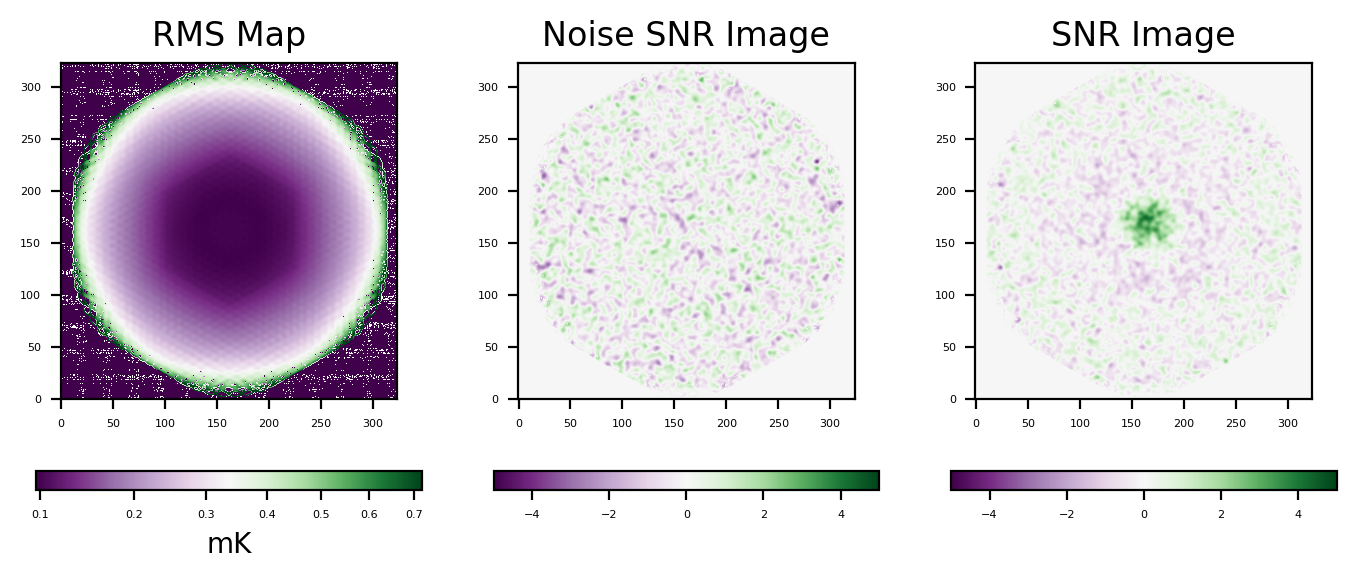

In [25]:
fig6 = plt.figure(6,figsize=(7,3),dpi=200)
fig6.clf()
vmax = 10
vmin = -vmax
linenorm = colors.Normalize(vmin=vmin, vmax=vmax) # Fairly important to SEE the difference
sqrtnorm = colors.FuncNorm((_forward, _inverse), vmin=minrms*1e3, vmax=maxrms*1e3)
mycmap=cm.get_cmap('PRGn')
#mydcm =cm.get_cmap('PRGn',256)
#newcolors = mydcm(np.linspace(0,1,256))
#mycmap.set_under(newcolors[0,:])
#mycmap.set_over('k')

ax6a = fig6.add_subplot(131)
im6a = ax6a.imshow(rmsmap*1e3,origin="lower",norm=sqrtnorm,cmap=mycmap)
ax6a.set_title("RMS Map")
ax6b = fig6.add_subplot(132)
im6b = ax6b.imshow(smnoisesnr,origin="lower",vmin=-5,vmax=5,cmap=mycmap)
ax6b.set_title("Noise SNR Image")
ax6c = fig6.add_subplot(133)
im6c = ax6c.imshow(smoothedsnr,origin="lower",norm=linenorm,cmap=mycmap)
ax6c.set_title("SNR Image")

cb1 = fig6.colorbar(im6a,location="bottom",ax=ax6a,label=r"mK")
cb2 = fig6.colorbar(im6b,location="bottom",ax=ax6b)
cb3 = fig6.colorbar(im6b,location="bottom",ax=ax6c)
for cb in [cb1,cb2,cb3]:
    cb.ax.tick_params(labelsize=4)

ax6a.tick_params(axis='both', labelsize=4)
ax6b.tick_params(axis='both', labelsize=4)
ax6c.tick_params(axis='both', labelsize=4)

fig6.tight_layout()

Now, let's move to looping over some reduction parameters and seeing what happens regarding signal, noise, and SNR

In [26]:
def get_peak_noise_snr(scan,synth_tod,xymap,ffilt,smfwhm=9.0,roi=2.0):
    
    xm,ym = xymap                   # unpack tuple
    pixsize = xm[1,0] - xm[0,0]     # pixel size, in arcseconds
    rmap  = np.sqrt(xm**2 + ym**2)  # radii, in arcseconds
    scan["wts"] = scan["wts"]*0 + 1 # Reset to ones...to be sure
    synth_ffilt = SSO.fourier_filter(scan["t"],synth_tod,ffilt) # Apply this filter to the TOD
    synth_cmsub = SSO.cmsub(synth_ffilt,scan["wts"])    # Subtract a common mode AFTER Fourier filtering
    scan["vals"] = synth_cmsub     # Put the TOD of your choice into the scan dictionary
    SSO.set_wts(scan)        # We now have some noise (realistic or not), so we ought to update our weights

    reducedmap,redowts = SSO.tod2map_v2((xm,ym),scan) # Then you can make a map like this
    smoothedmap             = imf.fourier_filtering_2d(reducedmap,"gauss",smfwhm/pixsize)
    smoothedsnr,smoothedwts = make_snr(smoothedmap,redowts,pixsize,fwhm=smfwhm)
    noise,nwts              = SSO.tod2map_v2((xm,ym),scan,noise=True,roll=True)
    smnoise                 = imf.fourier_filtering_2d(noise,"gauss",smfwhm/pixsize)
    smnoisesnr,smnowts      = make_snr(smnoise,nwts,pixsize,fwhm=smfwhm)
    nzwti                   = (redowts > 0)
    check                   = np.std(smnoisesnr[nzwti])    # This should be == 1 for a proper Gaussian dist.
    smoothedsnr            /= check                        # Correct maps by this factor
    smoothedwts            /= check**2                     # And the weight map appropriately too
    rmsmap                  = np.zeros(smoothedwts.shape)  # Now compute the RMS map
    rmsmap[nzwti]           = 1.0/np.sqrt(smoothedwts[nzwti])

    good_radii              = (rmap < roi*60) # roi in arcminutes, so now comparison is apples-to-apples
    peak_signal             = np.max(smoothedmap[good_radii])
    noise_in_roi            = np.std(smnoise[good_radii])
    peak_snr                = np.max(smoothedsnr[good_radii])
    
    return peak_signal,noise_in_roi,peak_snr

In [27]:
sminput  = imf.fourier_filtering_2d(twodg,"gauss",smfwhm/pixsize)
input_pk = np.max(sminput)

fhighs = np.arange(10)*0.01 + 0.05 # Go from 0.05 to 0.14 Hz for highpasses
flowps = np.arange(10)*4    + 20.0 # Go from 20 to 56 Hz
mypks = []; mynoi = []; mysnr = []

for fhigh in fhighs:
    ffilt = [fhigh,51.0]
    pk,noise,snr = get_peak_noise_snr(scan,synth_tod,(xm,ym),ffilt,smfwhm=9.0,roi=2.0)
    mypks.append(pk)
    mynoi.append(noise)
    mysnr.append(snr)
    
for fhigh,pk,noise,snr in zip(fhighs,mypks,mynoi,mysnr):
    ffilt = [fhigh,51.0]
    print(ffilt,pk,noise,snr)

[0.05, 51.0] 0.0009404513251978699 0.00010218298824032615 9.207077814648887
[0.060000000000000005, 51.0] 0.0008808209607773303 9.687036219761089e-05 8.839383267987989
[0.07, 51.0] 0.0008700132729852694 0.00010287571218640015 8.68707426442671
[0.08, 51.0] 0.0008570245266782809 9.444178145966709e-05 8.4708912033518
[0.09, 51.0] 0.000766527962466512 9.199125162401254e-05 7.984671234225148
[0.1, 51.0] 0.0007486454187252158 0.00010270025525472273 7.6312303954681
[0.11, 51.0] 0.0007367725472226538 0.00010024968866680745 7.538016169794702
[0.12000000000000001, 51.0] 0.000661466391493445 9.551780883930185e-05 6.856773507997252
[0.13, 51.0] 0.0006497210265651407 9.508598844706593e-05 6.755196013825974
[0.14, 51.0] 0.000650228621779539 9.838880189289491e-05 6.568592602603628


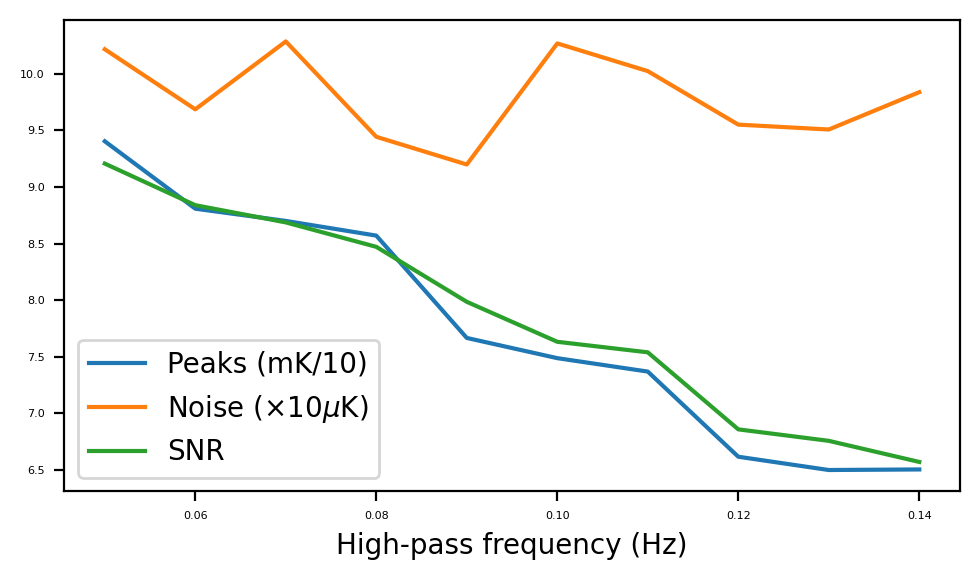

In [33]:
fig7 = plt.figure(7,figsize=(5,3),dpi=200)
fig7.clf()
ax7a = fig7.add_subplot(111)
ax7a.plot(fhighs,np.array(mypks)*1e4,label="Peaks (mK/10)")
ax7a.plot(fhighs,np.array(mynoi)*1e5,label=r"Noise ($\times 10 \mu$K)")
ax7a.plot(fhighs,np.array(mysnr),label="SNR")
ax7a.tick_params(axis='both', labelsize=4)
ax7a.set_xlabel("High-pass frequency (Hz)")
ax7a.legend()
fig7.tight_layout()
fig7.savefig("/home/charles/Documents/MUSTANG2/Figures/OutputVsFilteringParams.png")